# Maximization Bias and Double Learning 



In [1]:
from simple_mdp import SimpleMDP
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from itertools import chain

import matplotlib.pyplot as plt

env = SimpleMDP()
eps, alpha, gamma = 0.1, 0.1, 1.0

In [2]:
def argmax(values):
    '''
    Argmax with random ties breaking
    '''
    return np.random.choice(np.flatnonzero(values == values.max()))


def q_learning(env, episode_num=300):
    state_num = env.observation_space.n
    action_num = env.action_space.n
    q_values = np.zeros((state_num, action_num))

    actions = []
    for _ in range(episode_num):
        obs, done = env.reset(), False
        episode_actions = []
        while not done:
            if np.random.random() < eps:
                act = env.action_space.sample()
            else:
                act = argmax(q_values[obs])
            episode_actions.append(act)
            next_obs, reward, done, _ = env.step(act)
            q_values[obs][act] = q_values[obs][act] + alpha * (
                reward + gamma * np.max(q_values[next_obs]) - q_values[obs][act])
            obs = next_obs
        actions.append(episode_actions[0])  # Record the action executed in starting state
    return actions, q_values


def double_q_learning(env, episode_num=300):
    state_num = env.observation_space.n
    action_num = env.action_space.n
    q1 = np.zeros((state_num, action_num))
    q2 = np.zeros((state_num, action_num))

    actions = []
    for _ in range(episode_num):
        obs, done = env.reset(), False
        episode_actions = []
        while not done:
            if np.random.random() < eps:
                act = env.action_space.sample()
            else:
                q_values = q1 + q2
                act = argmax(q_values[obs])
            episode_actions.append(act)
            next_obs, reward, done, _ = env.step(act)
            # Double update
            if np.random.random() < 0.5:
                q1[obs][act] = q1[obs][act] + alpha * (
                    reward + gamma * q2[next_obs][argmax(q1[next_obs])] - q1[obs][act])
            else:
                q2[obs][act] = q2[obs][act] + alpha * (
                    reward + gamma * q1[next_obs][argmax(q2[next_obs])] - q2[obs][act])
            obs = next_obs
        actions.append(episode_actions[0])  # Record the action executed in starting state
    return actions, q_values


def run(algo_func, runs=1000):
    all_actions = []
    for _ in tqdm(range(runs)):
        actions, _ = algo_func(env)
        all_actions.append(actions)
    return all_actions

In [3]:
p_num = 10

with Pool(p_num) as p:
    all_actions = []
    for actions in p.map(run, [q_learning for _ in range(p_num)]):
        all_actions.extend(actions)
    q_learning_curve = 1 - (np.sum(np.array(all_actions), axis=0)) / 10000
    
    all_actions = []
    for actions in p.map(run, [double_q_learning for _ in range(p_num)]):
        all_actions.extend(actions)
    double_q_learning_curve = 1 - (np.sum(np.array(all_actions), axis=0)) / 10000

100%|██████████| 1000/1000 [00:12<00:00, 79.39it/s]


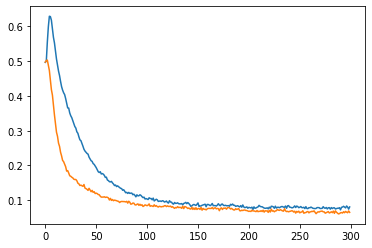

In [4]:
plt.plot(q_learning_curve)
plt.plot(double_q_learning_curve)

Double Q-Learning (orange curve) seems to eliminate the positive bias in the estimation of `max`.